/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4847 - loss: 1.5405 - val_accuracy: 0.8313 - val_loss: 0.5227
Epoch 2/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7790 - loss: 0.5995 - val_accuracy: 0.8490 - val_loss: 0.3756
Epoch 3/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8359 - loss: 0.4215 - val_accuracy: 0.8920 - val_loss: 0.2821
Epoch 4/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8564 - loss: 0.3705 - val_accuracy: 0.9008 - val_loss: 0.2550
Epoch 5/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8679 - loss: 0.3429 - val_accuracy: 0.9041 - val_loss: 0.2546
Epoch 6/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8698 - loss: 0.3242 - val_accuracy: 0.9063 - val_loss: 0.2401
Epoch 7/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8675 - loss: 0.3272 - val_accuracy: 0.9074 - val_loss: 0.2406
Epoch 8/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8678 - loss: 0.3200 - val_accuracy: 0.

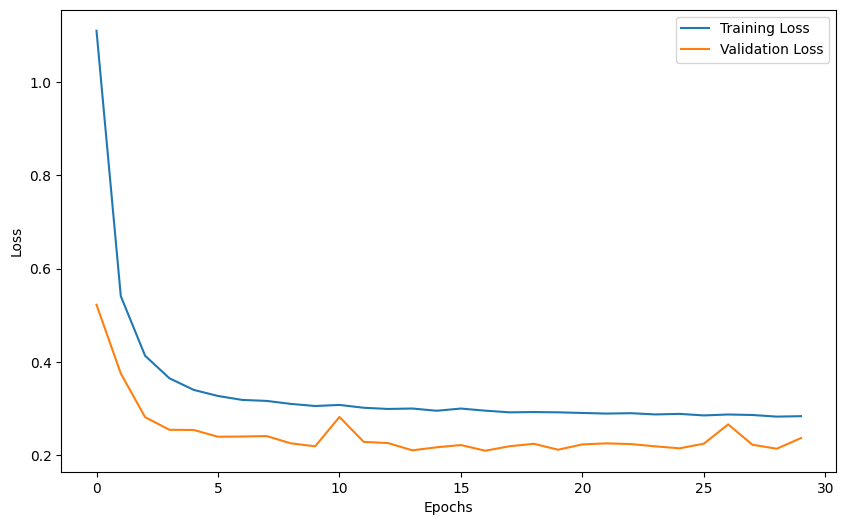

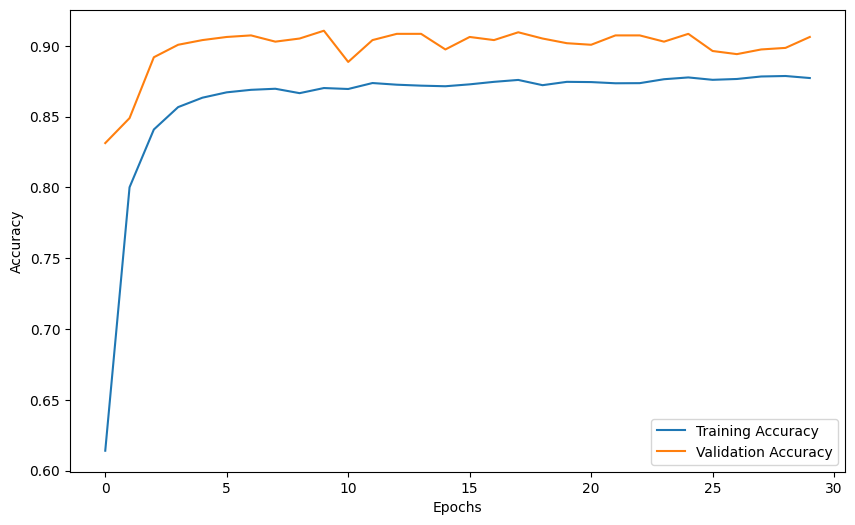

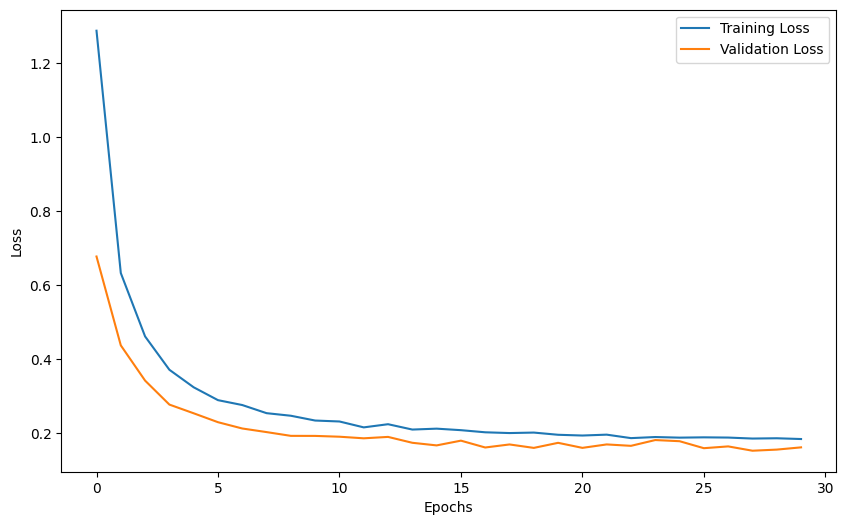

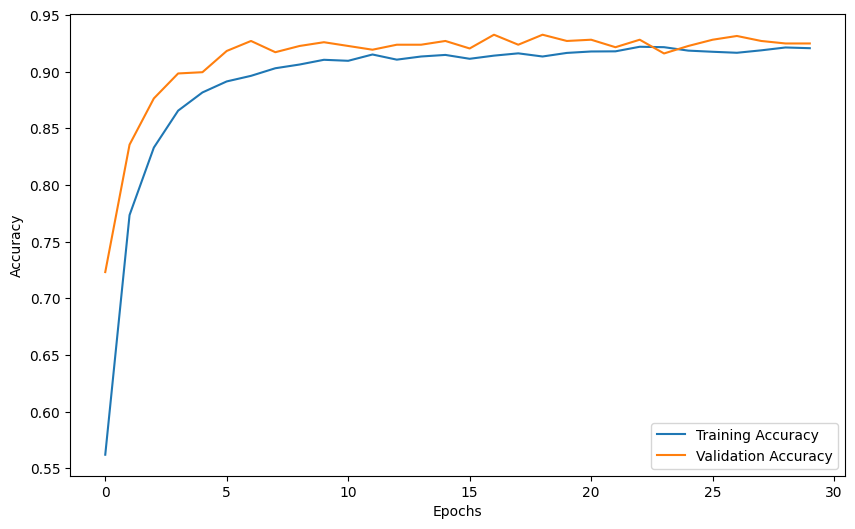

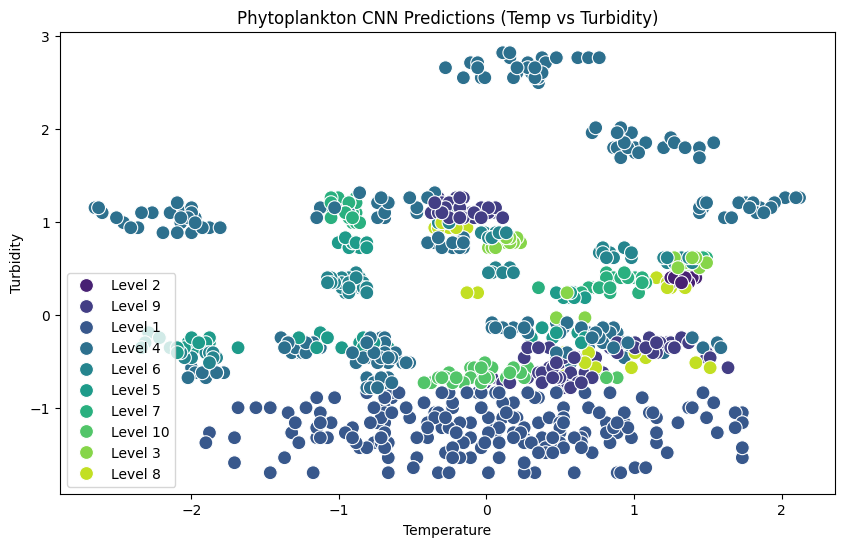

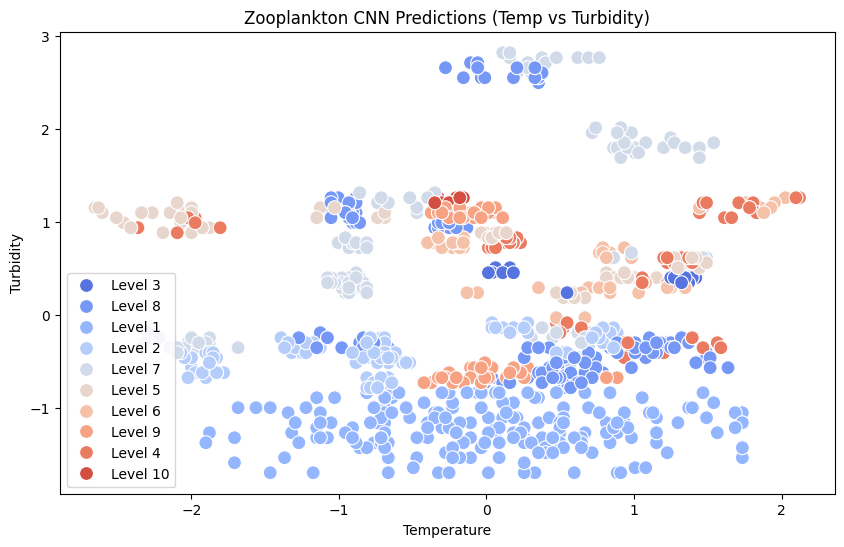

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (replace 'data.csv' with your dataset file)
df = pd.read_csv('6639leveling.csv')

# Separate features and target
X = df[['Temp', 'pH', 'TDS', 'Turbidity', 'DO']]
y_phyto = df['Phytoplankton']
y_zoo = df['Zooplankton']

# Encode text labels to numerical values
le_phyto = LabelEncoder()
le_zoo = LabelEncoder()
y_phyto_encoded = le_phyto.fit_transform(y_phyto)
y_zoo_encoded = le_zoo.fit_transform(y_zoo)

# Normalize the feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input data to 3D for CNN (CNN expects 3D input: samples, width, height)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)  # (samples, features, 1)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_phyto, y_test_phyto = train_test_split(X_reshaped, y_phyto_encoded, test_size=0.2, random_state=42)
X_train_zoo, X_test_zoo, y_train_zoo, y_test_zoo = train_test_split(X_reshaped, y_zoo_encoded, test_size=0.2, random_state=42)

# SMOTE for Phytoplankton
smote = SMOTE(random_state=42)
X_train_phyto_reshaped, y_train_phyto_balanced = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train_phyto)
X_train_phyto_balanced = X_train_phyto_reshaped.reshape(X_train_phyto_reshaped.shape[0], X_train.shape[1], 1)

# SMOTE for Zooplankton
X_train_zoo_reshaped, y_train_zoo_balanced = smote.fit_resample(X_train_zoo.reshape(X_train_zoo.shape[0], -1), y_train_zoo)
X_train_zoo_balanced = X_train_zoo_reshaped.reshape(X_train_zoo_reshaped.shape[0], X_train_zoo.shape[1], 1)

# Build the CNN model
def build_cnn_model(num_classes):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu'))

    # Global Max Pooling instead of MaxPooling1D
    model.add(layers.GlobalMaxPooling1D())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))  # Dropout to avoid overfitting
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Phytoplankton Model
phyto_model = build_cnn_model(num_classes=len(np.unique(y_train_phyto_balanced)))

# Zooplankton Model
zoo_model = build_cnn_model(num_classes=len(np.unique(y_train_zoo_balanced)))

# Train the Phytoplankton model
history_phyto = phyto_model.fit(X_train_phyto_balanced, y_train_phyto_balanced, epochs=30, batch_size=32, validation_data=(X_test, y_test_phyto))

# Train the Zooplankton model
history_zoo = zoo_model.fit(X_train_zoo_balanced, y_train_zoo_balanced, epochs=30, batch_size=32, validation_data=(X_test_zoo, y_test_zoo))

# Predictions for Phytoplankton
y_pred_phyto = phyto_model.predict(X_test)
y_pred_phyto_classes = np.argmax(y_pred_phyto, axis=1)

# Predictions for Zooplankton
y_pred_zoo = zoo_model.predict(X_test_zoo)
y_pred_zoo_classes = np.argmax(y_pred_zoo, axis=1)

# Evaluate the models
print("Phytoplankton Classification Report (CNN):")
print(classification_report(y_test_phyto, y_pred_phyto_classes, target_names=le_phyto.classes_))

print("Zooplankton Classification Report (CNN):")
print(classification_report(y_test_zoo, y_pred_zoo_classes, target_names=le_zoo.classes_))

# Plot Loss vs Epoch for Phytoplankton model
plt.figure(figsize=(10,6))
plt.plot(history_phyto.history['loss'], label='Training Loss')
plt.plot(history_phyto.history['val_loss'], label='Validation Loss')
#plt.title('Phytoplankton Model Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy vs Epoch for Phytoplankton model
plt.figure(figsize=(10,6))
plt.plot(history_phyto.history['accuracy'], label='Training Accuracy')
plt.plot(history_phyto.history['val_accuracy'], label='Validation Accuracy')
#plt.title('Phytoplankton Model Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss vs Epoch for Zooplankton model
plt.figure(figsize=(10,6))
plt.plot(history_zoo.history['loss'], label='Training Loss')
plt.plot(history_zoo.history['val_loss'], label='Validation Loss')
#plt.title('Zooplankton Model Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy vs Epoch for Zooplankton model
plt.figure(figsize=(10,6))
plt.plot(history_zoo.history['accuracy'], label='Training Accuracy')
plt.plot(history_zoo.history['val_accuracy'], label='Validation Accuracy')
#plt.title('Zooplankton Model Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Scatter plot visualization for CNN predictions
# Plot for Phytoplankton (Temp vs Turbidity)
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_test[:, 0].flatten(), y=X_test[:, 3].flatten(), hue=le_phyto.inverse_transform(y_pred_phyto_classes), palette='viridis', s=100)
plt.title('Phytoplankton CNN Predictions (Temp vs Turbidity)')
plt.xlabel('Temperature')
plt.ylabel('Turbidity')
plt.show()

# Plot for Zooplankton (Temp vs Turbidity)
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_test_zoo[:, 0].flatten(), y=X_test_zoo[:, 3].flatten(), hue=le_zoo.inverse_transform(y_pred_zoo_classes), palette='coolwarm', s=100)
plt.title('Zooplankton CNN Predictions (Temp vs Turbidity)')
plt.xlabel('Temperature')
plt.ylabel('Turbidity')
plt.show()


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras import models, layers

# Load dataset (replace 'data.csv' with your dataset file)
df = pd.read_csv('6639leveling.csv')

# Separate features and target
X = df[['Temp', 'pH', 'TDS', 'Turbidity', 'DO']]
y_phyto = df['Phytoplankton']
y_zoo = df['Zooplankton']

# Encode text labels to numerical values
le_phyto = LabelEncoder()
le_zoo = LabelEncoder()
y_phyto_encoded = le_phyto.fit_transform(y_phyto)
y_zoo_encoded = le_zoo.fit_transform(y_zoo)

# Normalize the feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input data to 3D for CNN (CNN expects 3D input: samples, width, height)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)  # (samples, features, 1)

# SMOTE to handle class imbalance
smote = SMOTE(random_state=42)

# Function to build the CNN model
def build_cnn_model(num_classes):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], 1)))
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu'))

    # Global Max Pooling instead of MaxPooling1D
    model.add(layers.GlobalMaxPooling1D())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))  # Dropout to avoid overfitting
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Number of folds for cross-validation
k_folds = 5

# Stratified K-Folds Cross-Validation for Phytoplankton
skf_phyto = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
cv_scores_phyto = []

for fold, (train_index, test_index) in enumerate(skf_phyto.split(X_scaled, y_phyto_encoded), 1):
    print(f"Fold {fold}/{k_folds} for Phytoplankton")

    # Train-test split for this fold
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_phyto_encoded[train_index], y_phyto_encoded[test_index]

    # Reshape the data for CNN
    X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], 1)
    X_test_fold = X_test_fold.reshape(X_test_fold.shape[0], X_test_fold.shape[1], 1)

    # SMOTE to balance classes
    X_train_fold_res, y_train_fold_res = smote.fit_resample(X_train_fold.reshape(X_train_fold.shape[0], -1), y_train_fold)
    X_train_fold_res = X_train_fold_res.reshape(X_train_fold_res.shape[0], X_train_fold.shape[1], 1)

    # Build and train the model
    phyto_model = build_cnn_model(num_classes=len(np.unique(y_train_fold_res)))
    phyto_model.fit(X_train_fold_res, y_train_fold_res, epochs=30, batch_size=32, verbose=0)

    # Evaluate on test fold
    scores = phyto_model.evaluate(X_test_fold, y_test_fold, verbose=0)
    cv_scores_phyto.append(scores[1])  # Append accuracy (index 1 of the evaluation)

# Print Cross-validation accuracy scores for Phytoplankton
print(f"\nCross-validation accuracy scores for Phytoplankton (CNN): {cv_scores_phyto}")
print(f"Mean Accuracy: {np.mean(cv_scores_phyto):.4f}, Std Deviation: {np.std(cv_scores_phyto):.4f}")


# Stratified K-Folds Cross-Validation for Zooplankton
skf_zoo = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
cv_scores_zoo = []

for fold, (train_index, test_index) in enumerate(skf_zoo.split(X_scaled, y_zoo_encoded), 1):
    print(f"Fold {fold}/{k_folds} for Zooplankton")

    # Train-test split for this fold
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_zoo_encoded[train_index], y_zoo_encoded[test_index]

    # Reshape the data for CNN
    X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], 1)
    X_test_fold = X_test_fold.reshape(X_test_fold.shape[0], X_test_fold.shape[1], 1)

    # SMOTE to balance classes
    X_train_fold_res, y_train_fold_res = smote.fit_resample(X_train_fold.reshape(X_train_fold.shape[0], -1), y_train_fold)
    X_train_fold_res = X_train_fold_res.reshape(X_train_fold_res.shape[0], X_train_fold.shape[1], 1)

    # Build and train the model
    zoo_model = build_cnn_model(num_classes=len(np.unique(y_train_fold_res)))
    zoo_model.fit(X_train_fold_res, y_train_fold_res, epochs=30, batch_size=32, verbose=0)

    # Evaluate on test fold
    scores = zoo_model.evaluate(X_test_fold, y_test_fold, verbose=0)
    cv_scores_zoo.append(scores[1])  # Append accuracy (index 1 of the evaluation)

# Print Cross-validation accuracy scores for Zooplankton
print(f"\nCross-validation accuracy scores for Zooplankton (CNN): {cv_scores_zoo}")
print(f"Mean Accuracy: {np.mean(cv_scores_zoo):.4f}, Std Deviation: {np.std(cv_scores_zoo):.4f}")


Fold 1/5 for Phytoplankton


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2/5 for Phytoplankton


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3/5 for Phytoplankton


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4/5 for Phytoplankton


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5/5 for Phytoplankton


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Cross-validation accuracy scores for Phytoplankton (CNN): [0.9062844514846802, 0.9073870182037354, 0.8875413537025452, 0.8952590823173523, 0.932671070098877]
Mean Accuracy: 0.9058, Std Deviation: 0.0153
Fold 1/5 for Zooplankton


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2/5 for Zooplankton


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3/5 for Zooplankton


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4/5 for Zooplankton


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5/5 for Zooplankton


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Cross-validation accuracy scores for Zooplankton (CNN): [0.9217199683189392, 0.9228224754333496, 0.9106945991516113, 0.8941565752029419, 0.8995584845542908]
Mean Accuracy: 0.9098, Std Deviation: 0.0115


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4841 - loss: 1.5303 - val_accuracy: 0.8026 - val_loss: 0.5178
Epoch 2/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7947 - loss: 0.5496 - val_accuracy: 0.8677 - val_loss: 0.3311
Epoch 3/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8419 - loss: 0.4119 - val_accuracy: 0.8908 - val_loss: 0.2690
Epoch 4/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8585 - loss: 0.3504 - val_accuracy: 0.9085 - val_loss: 0.2302
Epoch 5/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8639 - loss: 0.3261 - val_accuracy: 0.9096 - val_loss: 0.2284
Epoch 6/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8686 - loss: 0.3259 - val_accuracy: 0.9096 - val_loss: 0.2247
Epoch 7/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8754 - loss: 0.2993 - val_accuracy: 0.8964 - val_loss: 0.2430
Epoch 8/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8605 - loss: 0.3229 - val_accuracy: 0.

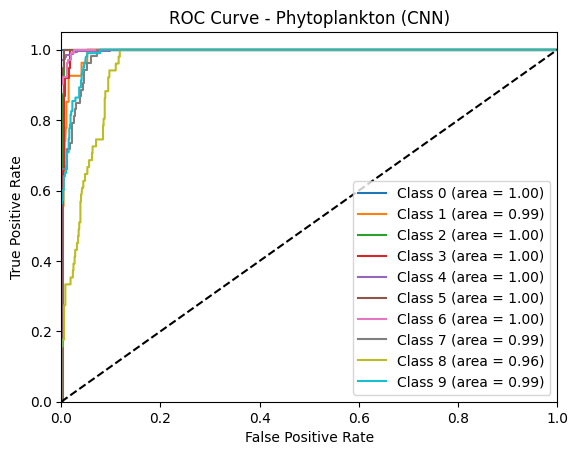

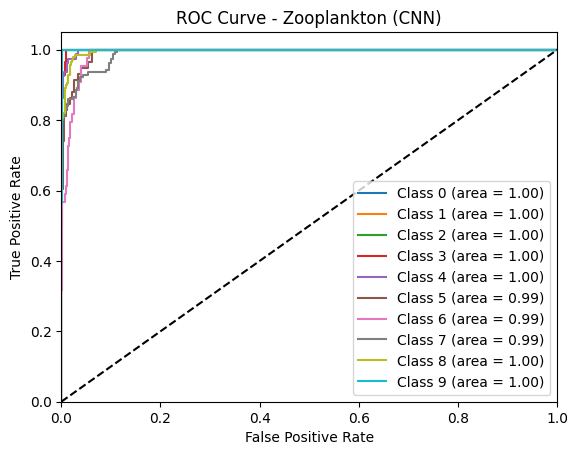

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cross-validation accuracy for Phytoplankton (CNN): 0.9098 (+/- 0.0128)
Cross-validation accuracy for Zooplankton (CNN): 0.9153 (+/- 0.0063)


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Load dataset (replace 'data.csv' with your dataset file)
df = pd.read_csv('6639leveling.csv')

# Separate features and target
X = df[['Temp', 'pH', 'TDS', 'Turbidity', 'DO']]
y_phyto = df['Phytoplankton']
y_zoo = df['Zooplankton']

# Encode text labels to numerical values
le_phyto = LabelEncoder()
le_zoo = LabelEncoder()
y_phyto_encoded = le_phyto.fit_transform(y_phyto)
y_zoo_encoded = le_zoo.fit_transform(y_zoo)

# Normalize the feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input data to 3D for CNN (CNN expects 3D input: samples, width, height)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)  # (samples, features, 1)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_phyto, y_test_phyto = train_test_split(X_reshaped, y_phyto_encoded, test_size=0.2, random_state=42)
X_train_zoo, X_test_zoo, y_train_zoo, y_test_zoo = train_test_split(X_reshaped, y_zoo_encoded, test_size=0.2, random_state=42)

# SMOTE for Phytoplankton
smote = SMOTE(random_state=42)
X_train_phyto_reshaped, y_train_phyto_balanced = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train_phyto)
X_train_phyto_balanced = X_train_phyto_reshaped.reshape(X_train_phyto_reshaped.shape[0], X_train.shape[1], 1)

# SMOTE for Zooplankton
X_train_zoo_reshaped, y_train_zoo_balanced = smote.fit_resample(X_train_zoo.reshape(X_train_zoo.shape[0], -1), y_train_zoo)
X_train_zoo_balanced = X_train_zoo_reshaped.reshape(X_train_zoo_reshaped.shape[0], X_train_zoo.shape[1], 1)

# Build the CNN model
def build_cnn_model(num_classes):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu'))

    # Global Max Pooling instead of MaxPooling1D
    model.add(layers.GlobalMaxPooling1D())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))  # Dropout to avoid overfitting
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Phytoplankton Model
phyto_model = build_cnn_model(num_classes=len(np.unique(y_train_phyto_balanced)))

# Zooplankton Model
zoo_model = build_cnn_model(num_classes=len(np.unique(y_train_zoo_balanced)))

# Train the Phytoplankton model
history_phyto = phyto_model.fit(X_train_phyto_balanced, y_train_phyto_balanced, epochs=30, batch_size=32, validation_data=(X_test, y_test_phyto))

# Train the Zooplankton model
history_zoo = zoo_model.fit(X_train_zoo_balanced, y_train_zoo_balanced, epochs=30, batch_size=32, validation_data=(X_test_zoo, y_test_zoo))

# Predictions for Phytoplankton
y_pred_phyto = phyto_model.predict(X_test)
y_pred_phyto_classes = np.argmax(y_pred_phyto, axis=1)

# Predictions for Zooplankton
y_pred_zoo = zoo_model.predict(X_test_zoo)
y_pred_zoo_classes = np.argmax(y_pred_zoo, axis=1)

# Evaluate the models
print("Phytoplankton Classification Report (CNN):")
print(classification_report(y_test_phyto, y_pred_phyto_classes, target_names=le_phyto.classes_))

print("Zooplankton Classification Report (CNN):")
print(classification_report(y_test_zoo, y_pred_zoo_classes, target_names=le_zoo.classes_))

# ROC Curve for multi-class classification
def plot_roc_curve_multi_class(y_test, y_pred, num_classes, title):
    # Binarize the output labels for multi-class ROC curve
    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve for Phytoplankton
plot_roc_curve_multi_class(y_test_phyto, y_pred_phyto, num_classes=len(np.unique(y_train_phyto_balanced)), title="Phytoplankton (CNN)")

# Plot ROC curve for Zooplankton
plot_roc_curve_multi_class(y_test_zoo, y_pred_zoo, num_classes=len(np.unique(y_train_zoo_balanced)), title="Zooplankton (CNN)")

# Stratified K-Fold Cross-Validation (5 folds)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_phyto = []
cv_scores_zoo = []

# Phytoplankton CV loop
for train, val in kfold.split(X_reshaped, y_phyto_encoded):
    # Build the model
    phyto_model_cv = build_cnn_model(num_classes=len(np.unique(y_train_phyto_balanced)))

    # Train the model on the current fold
    phyto_model_cv.fit(X_reshaped[train], y_phyto_encoded[train], epochs=30, batch_size=32, verbose=0)

    # Evaluate on the validation set
    scores_phyto = phyto_model_cv.evaluate(X_reshaped[val], y_phyto_encoded[val], verbose=0)
    cv_scores_phyto.append(scores_phyto[1])  # Append accuracy

# Zooplankton CV loop
for train, val in kfold.split(X_reshaped, y_zoo_encoded):
    # Build the model
    zoo_model_cv = build_cnn_model(num_classes=len(np.unique(y_train_zoo_balanced)))

    # Train the model on the current fold
    zoo_model_cv.fit(X_reshaped[train], y_zoo_encoded[train], epochs=30, batch_size=32, verbose=0)

    # Evaluate on the validation set
    scores_zoo = zoo_model_cv.evaluate(X_reshaped[val], y_zoo_encoded[val], verbose=0)
    cv_scores_zoo.append(scores_zoo[1])  # Append accuracy

# Print CV results
print(f"Cross-validation accuracy for Phytoplankton (CNN): {np.mean(cv_scores_phyto):.4f} (+/- {np.std(cv_scores_phyto):.4f})")
print(f"Cross-validation accuracy for Zooplankton (CNN): {np.mean(cv_scores_zoo):.4f} (+/- {np.std(cv_scores_zoo):.4f})")
